# Fidelity Prediction Of JanusQ-CT on Real Quantum Device

**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom


In this notebook, we use the fidelity dataset of a custom superconducting quantum devices to evaluate the fidelity prediction model of Janus-CT. This device is custom with 18 Xmon qubits arranged in a 6×3 grid qubit topology and use RX, RY, RZ, and CZ gates as basis gates, with gate times of 30 ns and 60 ns for single-qubit and two-qubit gates, respectively. The single-qubit gate fidelity, two-qubit fidelity and measurement are 99.97\%, 99.16\% and 94.91\%, repsecitvely, are benchmarked by isolated RB. For simultaneous RB, the single-qubit and two-qubit fidelities of both devices are above 99\% and 98\%, respectively.

<div style="text-align:center;">
    <img src="pictures/2-3.processor_topology.jpg"  width="20%" height="20%">
</div>

In [1]:
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.WARN)
import ray
ray.init(log_to_driver=False)#
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.baselines.fidelity_prediction.rb_prediction import RBModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.backend import  GridBackend

from janusq.tools.ray_func import map


import numpy as np

2024-04-19 04:09:55,518	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67067904 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-04-19 04:09:55,666	INFO worker.py:1724 -- Started a local Ray instance.


## Load fidelity dataset

In [2]:
from janusq.dataset import real_qc_18bit

circuits = real_qc_18bit
print(len(circuits))


2500


In [3]:
# limit the number of circuits to speedup the model construction
# circuits = circuits[:200]

In [4]:
sub_circuits, sub_fidelities = [], []
for circuit in circuits:
    for sub_cir in circuit.seperatable_circuits:
        sub_circuits.append(sub_cir)
        sub_fidelities.append(sub_cir.ground_truth_fidelity)

print(len(sub_circuits), len(sub_fidelities))

800 800


A large amount of zero-valued fidelities means less valid information, which negatively affects the training convergence and the model accuracy. For large-scale quantum device, e.g., 18-qubit device, we use seperable circuits to pervent the final fidelity from vanishing to zero due to a large number of gates. To address this, the separable circuits used in the fidelity dataset restrict the entangled qubits into sub-circuits within a small number of qubits.

<div style="text-align:center;">
    <img src="pictures/2-3.lagre_fidelity.jpg"  width="40%" height="40%">
</div>

In [5]:
# generate train datset and test dataset

from sklearn.model_selection import train_test_split
train_cirucits, test_circuits, train_fidelities, test_fidelities = train_test_split(sub_circuits,  sub_fidelities, test_size=.2)

## Build Vectorization Model

To train the fidelity prediction model, we first build the vectorization model for the quanutm device.

In [6]:
n_qubits = 18
n_steps = 1
n_walks = 20
backend = GridBackend(3,6)

vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
vec_model.train(circuits, multi_process = True, remove_redundancy = False)

100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


## Train Fidelity Model

In [7]:
fidelity_model = FidelityModel(vec_model)
fidelity_model.train((train_cirucits, train_fidelities), multi_process = False)

512it [00:00, 487621.17it/s]
/JanusQ/janusq/analysis/fidelity_prediction.py:89: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(vec_model.vectorize(circuit), jnp.float64)
128it [00:00, 534731.98it/s]


Janus-CT can also evaluate the weight of each path to identify high source of error. For example, when two gates leads to high error when they are in the same layer. It may result from crosstalk.

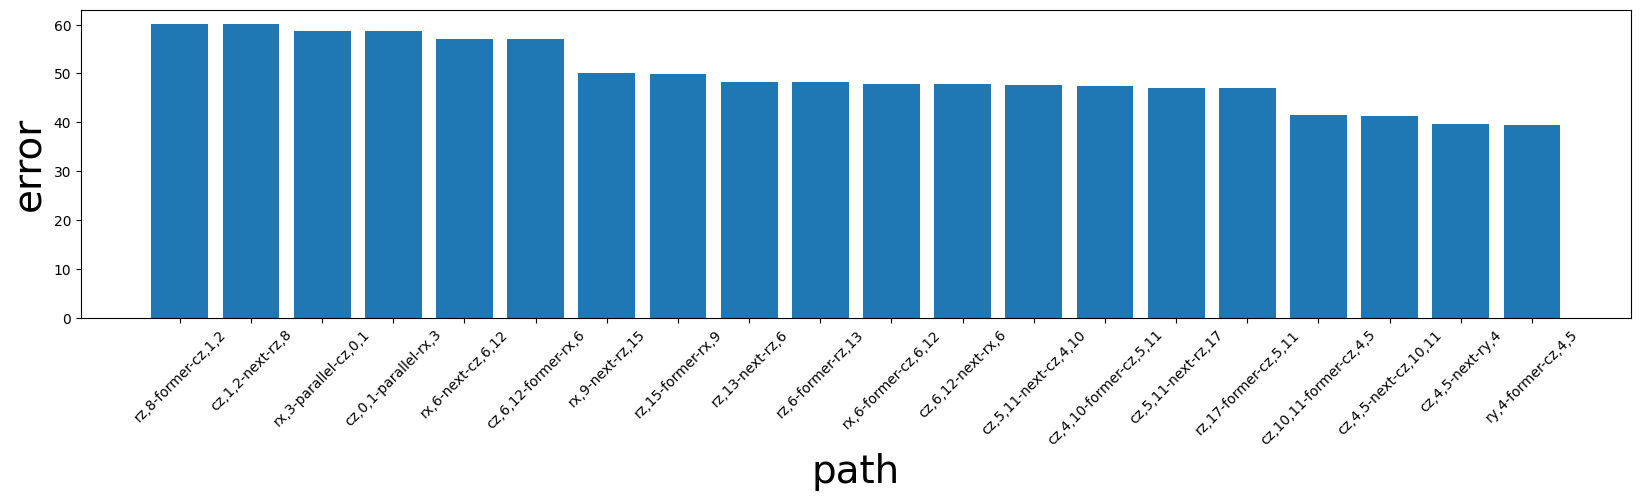

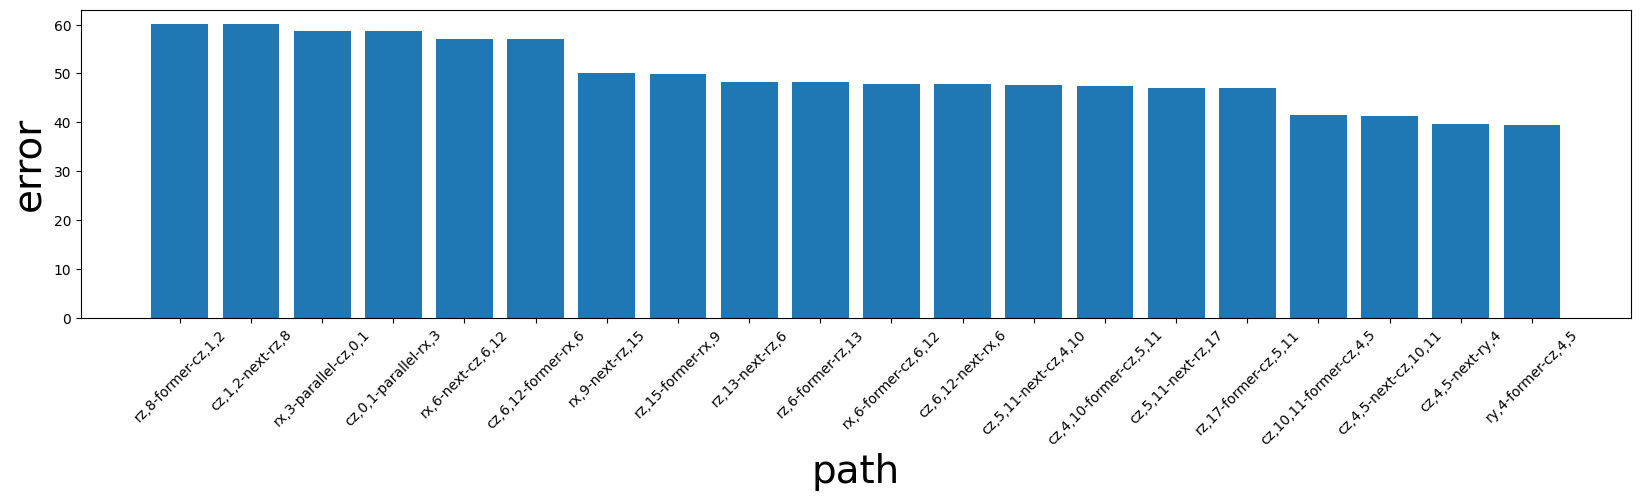

In [8]:
fidelity_model.plot_path_error()

## Compare to Random Benchmarking

In [9]:
# load the 1-q fidelities and 2-q fidelities of rb 
fidelity_1q_rb = {0: 0.9994094148043156, 1: 0.9993508083886652, 2: 0.9993513578387458, 3: 0.9996978330672296, 4: 0.9997258463524775, 
                           5: 0.9993898065578337, 6: 0.9998335484697743, 7: 0.9997460044815009,  8: 0.9997219426985601, 9: 0.9992924485427597, 
                           10: 0.9994018918682177, 11: 0.9998410411794697, 12: 0.9994231683912435, 13: 0.9995938422219371, 14: 0.9947661045069707, 
                           15: 0.9997576786354693, 16: 0.9998387638441334,  17: 0.9996691783504945} 
fidelity_2q_rb = {(5,11): 0.993651602350742, (11,17): 0.9943374306798481,  (4,5): 0.9810612795342519,  (10,11): 0.9915544427978213,  
                           (16,17): 0.9908639448675425,  (4,10): 0.9914941121128581,  (10,16): 0.9868303060599511,  (3,4): 0.9899226069903224,  
                           (9,10): 0.9945250360193374,  (15,16): 0.9933864398113101,  (3,9): 0.991508018299962,  (9,15): 0.993773364368622,  
                           (2,3): 0.9802169505904027,  (8,9): 0.9912794178832776,  (14,15): 0.9867247971867894,  (2,8): 0.9765590682588615,  
                           (8,14): 0.9863913339619792,  (1,2): 0.9713229087974011,  (7,8): 0.9908463216114999,  (13,14): 0.9564265490465305,  
                           (1,7): 0.9856880460026779,  (7,13): 0.9935440562158602,  (0,1): 0.9833453296232256,  (6,7): 0.9939901490743566,  
                           (12,13): 0.9821366244436676,  (0,6): 0.9861987068804432,  (6,12): 0.9863008252688662} 


In [10]:
rb_fidelities = np.array(map(lambda circuit: RBModel.get_rb_fidelity(circuit, fidelity_1q_rb, fidelity_2q_rb), test_circuits))
janusct_fidelities = np.array(map(lambda circuit: fidelity_model.predict_circuit_fidelity(circuit), test_circuits))


0.14621384291116296 0.6449529048714554
-0.07897675735423074 0.9766473126798304


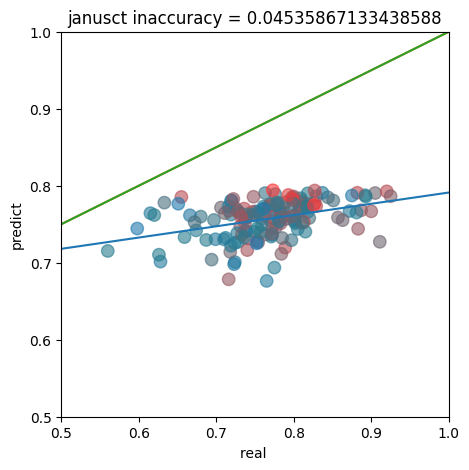

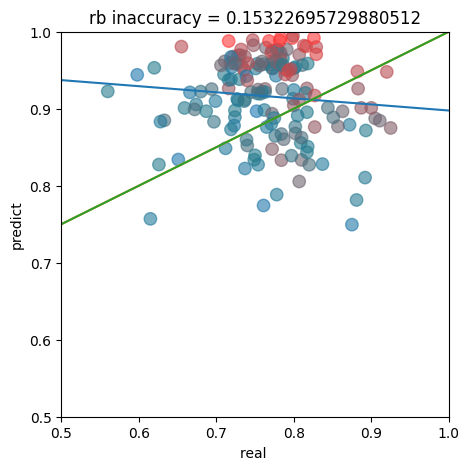

In [11]:

from janusq.tools.plot import plot_scaater

durations = np.array([cir.duration for cir in test_circuits])

fig_quct, axes_quct = plot_scaater(test_fidelities, janusct_fidelities, durations, title = f"janusct inaccuracy = {np.abs(test_fidelities - janusct_fidelities).mean()}")
fig_rb, axes_rb = plot_scaater(test_fidelities, rb_fidelities, durations, title = f"rb inaccuracy = {np.abs(test_fidelities - rb_fidelities).mean()}")